# Train and Test Classification Model

In [1]:
# NOTE: use Pipeline for feature engineering and model deployment

In [1]:
# Ignore all warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Import dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import imblearn.over_sampling as OS

# Import the modules to evaluate the models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_recall_curve
from sklearn.metrics import roc_curve, auc

# Import the models from SKLearn (Model 1 through Model 6)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# GridSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
# Local module
from ml_classification import model_performance

## Functions

In [3]:
# REPEATED FROM MODEL PERFORMANCE NOTEBOOK
def model_performance_metrics(y_test, y_proba, y_pred, model_name='Unnamed'):
    
    # Calculate accuraccy, precision, recall and F1-score
    accuracy = accuracy_score(y_test, y_pred)*100
    precision = precision_score(y_test, y_pred)*100
    recall = recall_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred)*100

    # Get P-R curve parameters (numpy arrays)
    p_curve, r_curve, t_curve = precision_recall_curve(y_test, y_proba)
    f1_scores = [f1_score(y_test, (y_proba >= t)) for t in t_curve]

    # ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)*100

    # ROC curve parameters
    roc_param = {
        'fpr': fpr,
        'tpr': tpr,
        'thr': thresholds
    }

    # Precision-Recall curve parameters
    pr_curve = {
        'p_curve': p_curve,
        'r_curve': r_curve,
        't_curve': t_curve,
        'f1_curve': f1_scores
    }

    # Group all metrics
    metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_score': auc_score
    }

    return metrics, pr_curve, roc_param

def plot_prcurve(pr_curve, model_name='Unnamed'):
    p_curve, r_curve, t_curve, f1_scores = pr_curve['p_curve'], pr_curve['r_curve'], pr_curve['t_curve'], pr_curve['f1_curve']

    # Plot curve
    fig, ax = plt.subplots(figsize=(10,6))

    sns.despine()
    
    ax.plot(t_curve, p_curve[:-1], label = 'Precision', ls='--', c=main_color)
    ax.plot(t_curve, r_curve[:-1], label = 'Recall', c=main_color)
    ax.plot(t_curve, f1_scores, label='F1 Curve', c=highlight_color)

    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Scores')
    
    ax.legend()
    
    fig.suptitle('Precision-Recall Curve')
    ax.set_title(f'Model: {model_name}')

    plt.show()

In [4]:
def upsample_smote(X_train, y_train, verbose=False):

	n_pos = np.sum(y_train == 1)
	n_neg = np.sum(y_train == 0)

	# Create Nx as many positive samples
	N = 50
	ratio = {1: n_pos*N, 0: n_neg}

	# Randomly oversample
	ROS = OS.SMOTE(
		sampling_strategy = ratio,
		random_state = 42
	)

	X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

	if verbose:
		print(f"Original Pos Class Count: {np.sum(y_train)}")
		print(f"Oversample Pos Class Count: {np.sum(y_train_rs)}")

	return X_train_rs, y_train_rs

## Load data

In [5]:
with open('feat_target.bin','rb') as f:
    features_target = pickle.load(f)

X = features_target['X']
y = features_target['y']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1,stratify=y, test_size=0.2)
X_train, y_train = upsample_smote(X_train, y_train)

## Train and test model

### Model 3: SVM

In [9]:
model = SVC()

params = {
    'probability': [True],
    'C': [.1, 1], # regularisation
    'kernel': ['linear', 'rbf', 'sigmoid'], # 'rbf', 'sigmoid', 'precomputed'],
    #'degree': [2, 3, 4],
    #'gamma': ['scale', 'auto'],
}

scoring='precision'

grid = RandomizedSearchCV(model, params, scoring=scoring, n_iter=10, verbose=1, n_jobs=-1)

# Train models
grid.fit(X_train, y_train)

# Get best parameters
tuned_svc_1 = SVC(**grid.best_params_).fit(X_train, y_train)

y_proba = tuned_svc_1.predict_proba(X_test)[:,1]
y_pred = tuned_svc_1.predict(X_test)

metrics_1, _, __ = model_performance_metrics(y_test, y_proba, y_pred, model_name='SVM random tuned (precision)')
display(pd.DataFrame([metrics_1]))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,model,accuracy,precision,recall,f1_score,auc_score
0,SVM random tuned (precision),99.264706,100.0,61.538462,76.190476,91.035252


In [10]:
grid.best_params_

{'probability': True, 'kernel': 'linear', 'C': 0.1}

In [11]:
model = SVC()

params = {
    'probability': [True],
    'C': np.linspace(.05, .2, 10), # regularisation
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

scoring='precision'

grid = GridSearchCV(model, params, scoring=scoring, verbose=3, n_jobs=-1)

# Train models
grid.fit(X_train, y_train)

# Get best parameters
tuned_svc_1 = SVC(**grid.best_params_).fit(X_train, y_train)

y_proba = tuned_svc_1.predict_proba(X_test)[:,1]
y_pred = tuned_svc_1.predict(X_test)

metrics_1, _, __ = model_performance_metrics(y_test, y_proba, y_pred, model_name='SVM random tuned (precision)')
display(pd.DataFrame([metrics_1]))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,model,accuracy,precision,recall,f1_score,auc_score
0,SVM random tuned (precision),99.264706,100.0,61.538462,76.190476,91.228745


In [12]:
model = SVC()

params = {
    'probability': [True],
    'C': np.linspace(.05, .2, 10), # regularisation
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

scoring='recall'

grid = GridSearchCV(model, params, scoring=scoring, verbose=3, n_jobs=-1)

# Train models
grid.fit(X_train, y_train)

# Get best parameters
tuned_svc_2 = SVC(**grid.best_params_).fit(X_train, y_train)

y_proba = tuned_svc_2.predict_proba(X_test)[:,1]
y_pred = tuned_svc_2.predict(X_test)

metrics_2, _, __ = model_performance_metrics(y_test, y_proba, y_pred, model_name='SVM random tuned (recall)')
display(pd.DataFrame([metrics_2]))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,model,accuracy,precision,recall,f1_score,auc_score
0,SVM random tuned (recall),98.578431,63.157895,61.538462,62.337662,94.415613


In [14]:
grid.best_params_

{'C': 0.2, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True}

In [13]:
display(pd.DataFrame([metrics_1, metrics_2]))

,model,accuracy,precision,recall,f1_score,auc_score
0,SVM random tuned (precision),99.264706,100.000000,61.538462,76.190476,91.228745
1,SVM random tuned (recall),98.578431,63.157895,61.538462,62.337662,94.415613


## Evaluation of final model

In [18]:
# Define plot parameters
main_color = '#969696'
highlight_color = '#04bfb3'
default_figsize = (10,6)

In [19]:
def plot_prcurve(pr_curve, model_name='Unnamed'):
    p_curve, r_curve, t_curve, f1_scores = pr_curve['p_curve'], pr_curve['r_curve'], pr_curve['t_curve'], pr_curve['f1_curve']

    # Plot curve
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(t_curve, p_curve[:-1], label = 'Precision', ls='--', c=main_color)
    ax.plot(t_curve, r_curve[:-1], label = 'Recall', c=main_color)
    ax.plot(t_curve, f1_scores, label='F1 Curve', c=highlight_color)

    ax.set_xlabel('Prediction Threshold')
    ax.set_ylabel('Scores')
    
    ax.legend()
    
    fig.suptitle('Precision-Recall Curve')
    ax.set_title(f'Model: {model_name}')

    plt.show()

def plot_roc_curve(roc_param, metrics, model_name='Unnamed'):
    fpr, tpr, thresholds, auc_score = roc_param['fpr'], roc_param['tpr'], roc_param['thr'], metrics['auc_score']

    # Plot the ROC Curve
    fig, ax = plt.subplots(figsize=(10,6))
    
    ax.plot(fpr, tpr, label = f'Model (AUC = {auc_score/100:.2f})', c=highlight_color)
    ax.plot([0,1], [0,1], 'k--', label = 'Random Guess (AUC = 0.5)', c=main_color)

    # Formatting
    ax.set_xlabel('False Postive Rate')
    ax.set_ylabel('True Postive Rate')

    fig.suptitle('ROC Curve')
    ax.set_title(f'Model: {model_name}')
    
    ax.legend()
    plt.show()

def show_confusion_matrix(matrix, title, save=False):
    fig, ax = plt.subplots()

    sns.heatmap(
        matrix,
        annot=True,
        fmt='g',
        square=True,
        xticklabels=['0', '1'],
        yticklabels=['0', '1'],
        cmap=sns.color_palette(f"light:{highlight_color}", as_cmap=True)
    ).set(
        xlabel='ACTUAL',
        ylabel='PREDICTED',
        title=title
    )

    if save:
        plt.savefig(f'{title}.png')
    
    plt.show()

In [15]:
params = {'probability': True, 'kernel': 'linear', 'C': 0.1}

In [20]:
# Get best parameters
tuned_svc_1 = SVC(**params).fit(X_train, y_train)

y_proba = tuned_svc_1.predict_proba(X_test)[:,1]
y_pred = tuned_svc_1.predict(X_test)

metrics_1, pr_curve, roc_param = model_performance_metrics(y_test, y_proba, y_pred, model_name='SVM random tuned (precision)')
display(pd.DataFrame([metrics_1]))

,model,accuracy,precision,recall,f1_score,auc_score
0,SVM random tuned (precision),99.264706,100.0,61.538462,76.190476,91.035252


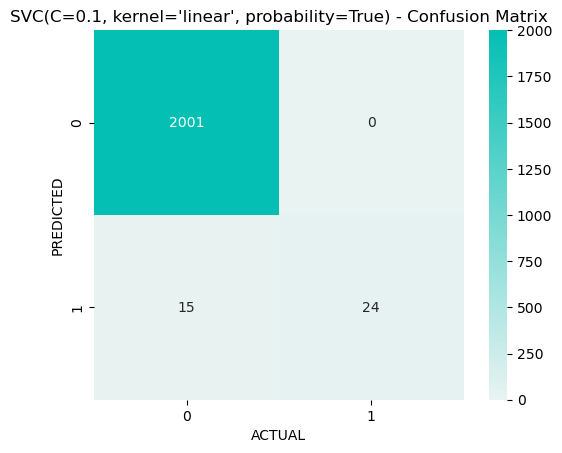

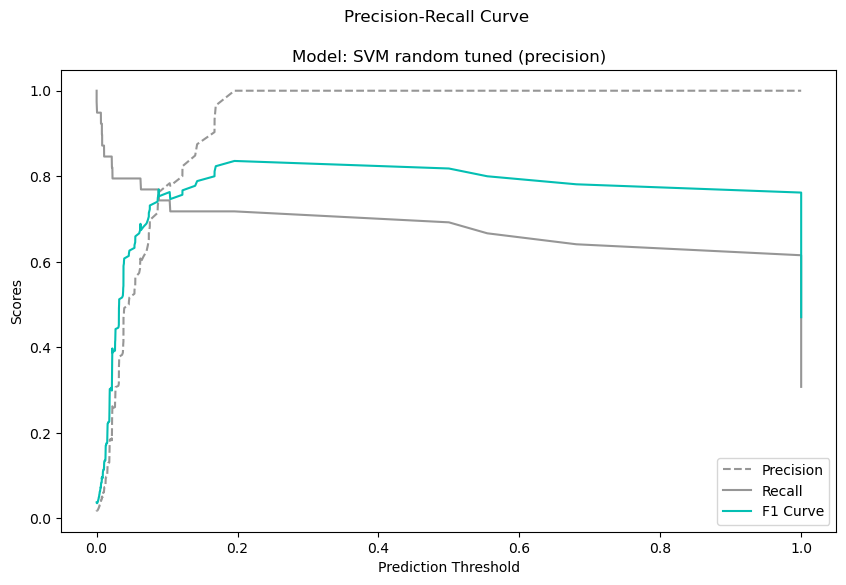

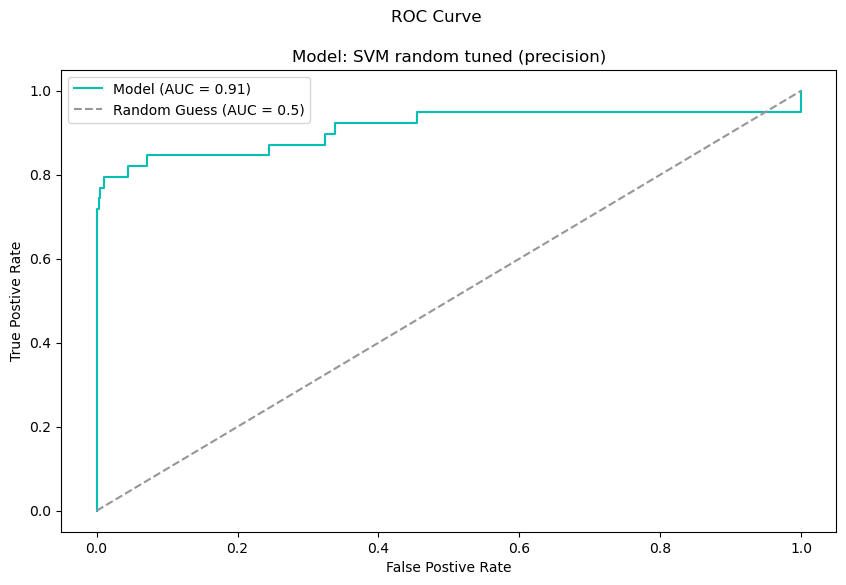

In [21]:
# Compute and display confusion matrix
model_4_cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(model_4_cm, f'{tuned_svc_1} - Confusion Matrix')

# Plot Precision-Recall Curve
plot_prcurve(pr_curve, 'SVM random tuned (precision)')

# ROC Curve
plot_roc_curve(roc_param, metrics_1, 'SVM random tuned (precision)')

In [22]:
# Index where F1 curve is maximised in Model 5 (SVM)
f1_max_5 = pr_curve['f1_curve'].index(max(pr_curve['f1_curve']))

tuned_metrics_5 = pd.DataFrame([{
    'model': metrics_1['model'],
    'threshold': pr_curve['t_curve'][f1_max_5],
    'precision': pr_curve['p_curve'][f1_max_5],
    'recall': pr_curve['r_curve'][f1_max_5],
    'f1_score': pr_curve['f1_curve'][f1_max_5]
}])

tuned_metrics_5

,model,threshold,precision,recall,f1_score
0,SVM random tuned (precision),0.195584,1.0,0.717949,0.835821


In [24]:
opt_threshold = pr_curve['t_curve'][f1_max_5]
opt_threshold

0.19558396433013217

In [31]:
y_pred_th = (y_proba > opt_threshold)*1
y_pred_th

array([0, 0, 0, ..., 0, 0, 0])

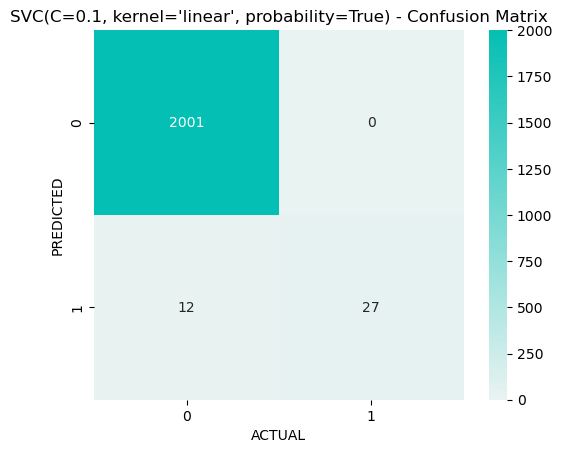

In [32]:
# Compute and display confusion matrix
model_cm = confusion_matrix(y_test, y_pred_th)
show_confusion_matrix(model_cm, f'{tuned_svc_1} - Confusion Matrix')

## Pickle model and scaler
While other models provide better performance, they do not directly provide probability estimates. Since this is important to give finer information to the user, Model 2 (Logistics Regression with scaling) is kept instead.

In [43]:
# Save best model
with open('../Server/blackbox.model','wb') as f:
    pickle.dump(model_2,f)

# Save scaling
with open('../Server/blackbox.scaler','wb') as f:
    pickle.dump(X_scaler,f)